# Cluster Shear Profile Demonstration

This notebook demonstrates the usage of the `ClusterShearProfile` class from the `crow` package, which computes the excess surface mass density (ΔΣ) and reduced tangential shear (gₜ) of galaxy clusters. We will also demonstrate interpolation of geometric lensing efficiency and miscentering corrections.


In [1]:
# Imports
import time
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from scipy.interpolate import interp1d

from crow import ClusterShearProfile


## 1. Setup Cosmology and Halo Mass Function

We use PyCCL to define a cosmology and a halo mass function.


In [2]:
# Cosmology
cosmo = ccl.Cosmology(
    Omega_c=0.2607,
    Omega_b=0.04897,
    h=0.6766,
    sigma8=0.8102,
    n_s=0.9665,
)

# Halo mass function
hmf = ccl.halos.MassFuncTinker08(mass_def="200c")

## 2. Initialize ClusterShearProfile Objects

We create six variants of `ClusterShearProfile` to demonstrate different use cases:

1. Delta sigma (`is_delta_sigma=True`) with `cluster_concentration=None`
2. Delta sigma (`is_delta_sigma=True`) with fixed concentration
3. Delta sigma with miscentering
4. Reduced shear (`is_delta_sigma=False`)
5. Reduced shear with beta interpolation
6. Reduced shear with beta interpolation and miscentering


In [3]:
# 1. Delta sigma, concentration = None
cl_delta_sigma_none = ClusterShearProfile(
    cosmo, hmf, is_delta_sigma=True
)

# 2. Delta sigma, fixed concentration
cl_delta_sigma_fixed = ClusterShearProfile(
    cosmo, hmf, cluster_concentration=4.0, is_delta_sigma=True
)

# 3. Delta sigma with miscentering
cl_delta_sigma_mis = ClusterShearProfile(
    cosmo, hmf, cluster_concentration=4.0, is_delta_sigma=True
)
cl_delta_sigma_mis.set_miscentering(miscentering_fraction=0.2)

# 4. Reduced shear, exact
cl_reduced_shear = ClusterShearProfile(
    cosmo, hmf, cluster_concentration=4.0, is_delta_sigma=False
)
cl_reduced_shear.set_beta_parameters(z_inf=10)

# 5. Reduced shear with beta interpolation
cl_reduced_shear_interp = ClusterShearProfile(
    cosmo, hmf, cluster_concentration=4.0, is_delta_sigma=False, use_beta_s_interp=True
)
cl_reduced_shear_interp.set_beta_parameters(z_inf=10)
cl_reduced_shear_interp.set_beta_s_interp(1.1, 1.3, 5)

# 6. Reduced shear with beta interpolation + miscentering
cl_reduced_shear_interp_mis = ClusterShearProfile(
    cosmo, hmf, cluster_concentration=4.0, is_delta_sigma=False, use_beta_s_interp=True
)
cl_reduced_shear_interp_mis.set_beta_parameters(z_inf=10)
cl_reduced_shear_interp_mis.set_beta_s_interp(1.1, 1.3, 5)
cl_reduced_shear_interp_mis.set_miscentering(miscentering_fraction=0.2)

# 7. Reduced shear exact + miscentering
cl_reduced_shear_mis = ClusterShearProfile(
    cosmo, hmf, cluster_concentration=4.0, is_delta_sigma=False, use_beta_s_interp=False
)
cl_reduced_shear_mis.set_beta_parameters(z_inf=10)
cl_reduced_shear_mis.set_miscentering(miscentering_fraction=0.2)

## 3. Test values of shear profile

In [4]:
import time

# Example cluster mass and redshift
log_mass = [13.0]
z = [1.2]
radius = 3.0

# 1. Delta sigma, concentration = None
start = time.time()
ds_val_none = cl_delta_sigma_none.compute_shear_profile(log_mass, z, radius)
end = time.time()
print("Delta sigma (None concentration):", ds_val_none, "| Time:", end - start, "s")

# 2. Delta sigma, fixed concentration
start = time.time()
ds_val_fixed = cl_delta_sigma_fixed.compute_shear_profile(log_mass, z, radius)
end = time.time()
print("Delta sigma (fixed concentration):", ds_val_fixed, "| Time:", end - start, "s")

# 3. Delta sigma with miscentering
start = time.time()
ds_val_mis = cl_delta_sigma_mis.compute_shear_profile(log_mass, z, radius)
end = time.time()
print("Delta sigma with miscentering:", ds_val_mis, "| Time:", end - start, "s")

# 4. Reduced shear, exact
start = time.time()
gt_val_exact = cl_reduced_shear.compute_shear_profile(log_mass, z, radius)
end = time.time()
print("Reduced shear exact:", gt_val_exact, "| Time:", end - start, "s")

# 5. Reduced shear with beta interpolation
start = time.time()
gt_val_interp = cl_reduced_shear_interp.compute_shear_profile(log_mass, z, radius)
end = time.time()
print("Reduced shear with beta interpolation:", gt_val_interp, "| Time:", end - start, "s")

# 6. Reduced shear with beta interpolation + miscentering
start = time.time()
gt_val_interp_mis = cl_reduced_shear_interp_mis.compute_shear_profile(log_mass, z, radius)
end = time.time()
print("Reduced shear with beta interpolation + miscentering:", gt_val_interp_mis, "| Time:", end - start, "s")

# 7. Reduced shear exact + miscentering
start = time.time()
gt_val_mis = cl_reduced_shear_mis.compute_shear_profile(log_mass, z, radius)
end = time.time()
print("Reduced shear exact + miscentering:", gt_val_mis, "| Time:", end - start, "s")

Delta sigma (None concentration): [1.21510978e+12] | Time: 0.596865177154541 s
Delta sigma (fixed concentration): [1.13451921e+12] | Time: 0.0007302761077880859 s
Delta sigma with miscentering: [1.12940013e+12] | Time: 6.409859895706177 s
Reduced shear exact: [0.00027987] | Time: 0.006938934326171875 s
Reduced shear with beta interpolation: [0.00027987] | Time: 0.0008673667907714844 s
Reduced shear with beta interpolation + miscentering: [0.00022393] | Time: 0.05245375633239746 s
Reduced shear exact + miscentering: [0.00022393] | Time: 0.056212425231933594 s


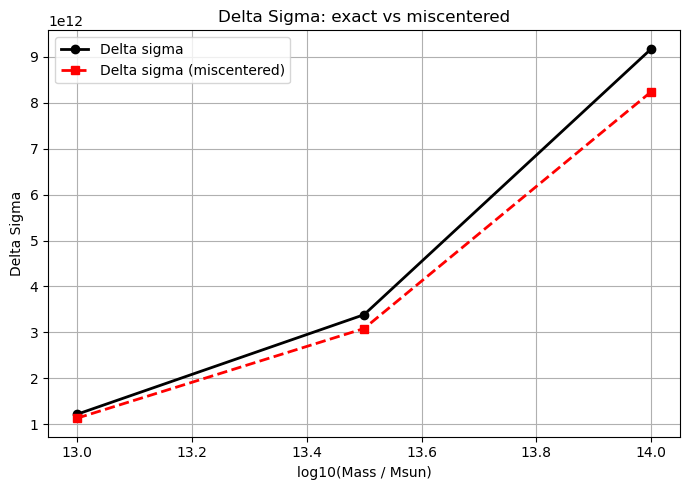

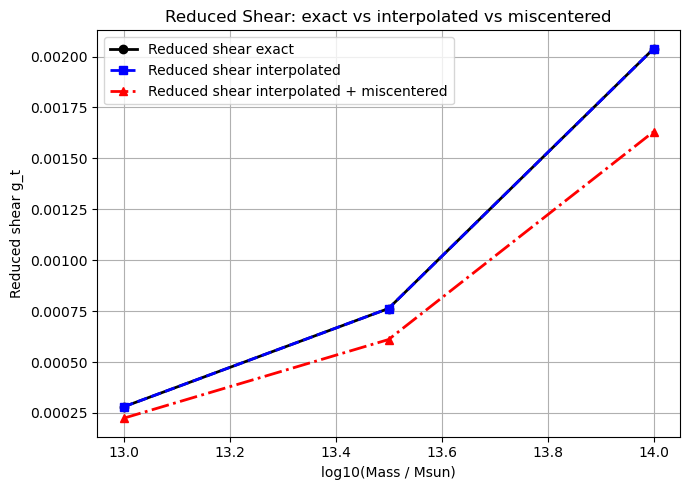

In [12]:
# Example cluster masses, single redshift and radius
log_masses = [13.0, 13.5, 14.0]
z = [1.2]
radius = 3.0

# Containers for results
results_ds = {'No conc': [], 'Miscentered': []}
results_g = {'Exact': [], 'Interp': [], 'Interp+Mis': []}

# Compute delta sigma and reduced shear for all masses
for log_mass in log_masses:
    # -----------------
    # Delta sigma
    # -----------------
    ds_none = cl_delta_sigma_none.compute_shear_profile([log_mass], z, radius)[0]
    ds_mis = cl_delta_sigma_mis.compute_shear_profile([log_mass], z, radius)[0]
    results_ds['No conc'].append(ds_none)
    results_ds['Miscentered'].append(ds_mis)
    
    # -----------------
    # Reduced shear
    # -----------------
    g_exact = cl_reduced_shear.compute_shear_profile([log_mass], z, radius)[0]
    g_interp = cl_reduced_shear_interp.compute_shear_profile([log_mass], z, radius)[0]
    g_interp_mis = cl_reduced_shear_interp_mis.compute_shear_profile([log_mass], z, radius)[0]
    
    results_g['Exact'].append(g_exact)
    results_g['Interp'].append(g_interp)
    results_g['Interp+Mis'].append(g_interp_mis)

# -----------------
# Plot Delta Sigma
# -----------------
plt.figure(figsize=(7, 5))
plt.plot(log_masses, results_ds['No conc'], 'k-o', lw=2, label='Delta sigma')
plt.plot(log_masses, results_ds['Miscentered'], 'r--s', lw=2, label='Delta sigma (miscentered)')
plt.xlabel('log10(Mass / Msun)')
plt.ylabel('Delta Sigma')
plt.title('Delta Sigma: exact vs miscentered')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------
# Plot Reduced Shear
# -----------------
plt.figure(figsize=(7, 5))
plt.plot(log_masses, results_g['Exact'], 'k-o', lw=2, label='Reduced shear exact')
plt.plot(log_masses, results_g['Interp'], 'b--s', lw=2, label='Reduced shear interpolated')
plt.plot(log_masses, results_g['Interp+Mis'], 'r-.^', lw=2, label='Reduced shear interpolated + miscentered')
plt.xlabel('log10(Mass / Msun)')
plt.ylabel('Reduced shear g_t')
plt.title('Reduced Shear: exact vs interpolated vs miscentered')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 4. Verify Beta_s Interpolation Accuracy Across Redshift Bins

This cell evaluates the precision of the `beta_s` interpolation implemented in the `ClusterShearProfile` class.

For several cluster redshift bins, the code:

1. Computes the **exact mean geometric lensing efficiency** (`beta_s`) and its square (`beta_s^2`) from the source redshift distribution using CLMM utilities.
2. Generates a **quadratic interpolation** of `beta_s` using a few key points within each bin.
3. Compares the interpolated values with the exact ones, both visually and by calculating the **relative error**.

The cell produces two sets of plots for each redshift bin:

- **Exact vs. interpolated values:** Shows how the quadratic interpolation reproduces the exact `beta_s` and `beta_s^2` profiles.
- **Relative error:** Quantifies the interpolation accuracy, confirming that even with a small number of interpolation points, the error remains very low, validating the use of interpolation for efficient cluster shear calculations.


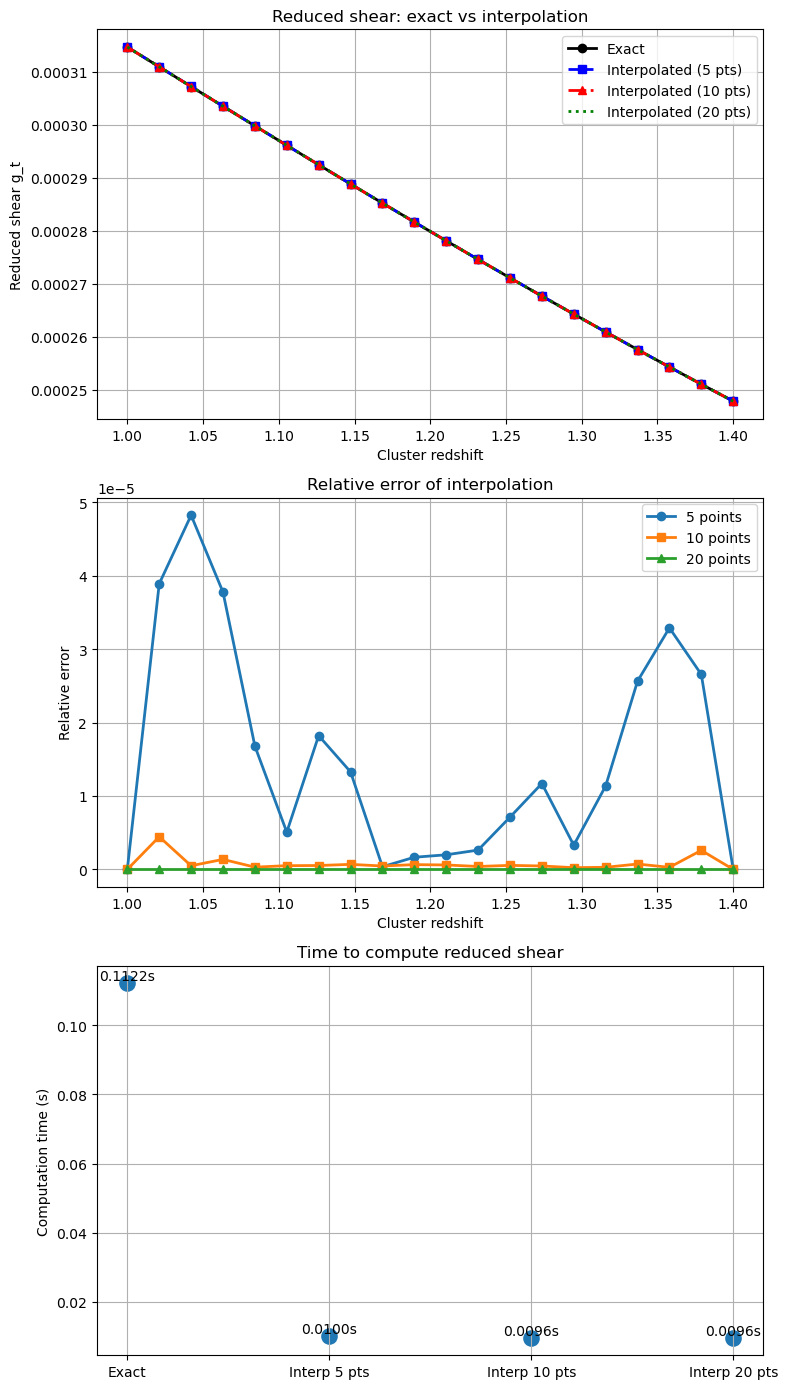

In [11]:
# -------------------------------
# Combined figure with 3 subplots
# -------------------------------
fig, axes = plt.subplots(3, 1, figsize=(8, 14), sharex=False)

# ---------------------------------------------------
# 1) Reduced shear curves
# ---------------------------------------------------
ax = axes[0]
ax.plot(z_cls, results['Exact']['values'], 'k-o', label='Exact', lw=2)
ax.plot(z_cls, results['Interp 5 pts']['values'], 'b--s', label='Interpolated (5 pts)', lw=2)
ax.plot(z_cls, results['Interp 10 pts']['values'], 'r-.^', label='Interpolated (10 pts)', lw=2)
ax.plot(z_cls, results['Interp 20 pts']['values'], 'g:', label='Interpolated (20 pts)', lw=2)

ax.set_xlabel('Cluster redshift')
ax.set_ylabel('Reduced shear g_t')
ax.set_title('Reduced shear: exact vs interpolation')
ax.legend()
ax.grid(True)

# ---------------------------------------------------
# 2) Relative error curves
# ---------------------------------------------------
ax = axes[1]
for n_points in [5, 10, 20]:
    rel_err = np.abs(results[f'Interp {n_points} pts']['values'] - results['Exact']['values']) / results['Exact']['values']
    ax.plot(z_cls, rel_err, lw=2, label=f'{n_points} points',
            marker='o' if n_points == 5 else ('s' if n_points == 10 else '^'))

ax.set_xlabel('Cluster redshift')
ax.set_ylabel('Relative error')
ax.set_title('Relative error of interpolation')
ax.legend()
ax.grid(True)

# ---------------------------------------------------
# 3) Computation times (scatter instead of histogram)
# ---------------------------------------------------
ax = axes[2]

labels = list(results.keys())
times = [results[key]['time'] for key in labels]

ax.scatter(labels, times, s=120)
for lbl, t in zip(labels, times):
    ax.text(lbl, t, f"{t:.4f}s", ha='center', va='bottom')

ax.set_ylabel('Computation time (s)')
ax.set_title('Time to compute reduced shear')
ax.grid(True)

plt.tight_layout()
plt.show()
